## Import Library

In [45]:
# Image Processing and Manipulation
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
import math
import os

# Data Handling and Analysis
import pandas as pd
from scipy.stats import skew, kurtosis

# Feature Extraction
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

# Utilities and Visualization
from tqdm import tqdm
import seaborn as sns

# Machine Learning - Model Building and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import Data and Library

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Dataset

In [47]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset.zip"   # ganti dengan nama file kamu

extract_dir = "tb_dataset"  # folder tujuan extract
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Selesai extract ke:", extract_dir)


Selesai extract ke: tb_dataset


# Sample Dataset

In [48]:
def show_pair(img_before, img_after, title_before="Before", title_after="After"):
    plt.figure(figsize=(10,5))

    # kiri
    plt.subplot(1,2,1)
    plt.imshow(img_before, cmap='gray', vmin=0, vmax=255)
    plt.title(title_before)
    plt.axis("off")

    # kanan
    plt.subplot(1,2,2)
    plt.imshow(img_after, cmap='gray', vmin=0, vmax=255)
    plt.title(title_after)
    plt.axis("off")

    plt.show()


In [49]:
# CELL 1: Upload / Unzip / Inspect dataset
# Jika di Colab, gunakan google.colab.files.upload(), kalau lokal pastikan ZIP_PATH benar.

import zipfile
import glob

# PILIH salah satu metode:
#  A) jika sudah ada file zip lokal, masukkan path di bawah:
ZIP_PATH = "/content/drive/MyDrive/Dataset.zip"   # <--- ganti sesuai file kamu
EXTRACT_DIR = "tb_dataset"

#  B) atau jika kamu sudah extract manual, set EXTRACT_DIR ke folder dataset

# Unzip (aman, idempotent)
os.makedirs(EXTRACT_DIR, exist_ok=True)
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_DIR)
    print("Extracted zip to", EXTRACT_DIR)
else:
    print("ZIP_PATH not found. Jika file sudah di-extract, set EXTRACT_DIR ke folder dataset yang benar.")
    # list subfolders if exists
if os.path.exists(EXTRACT_DIR):
    for root, dirs, files in os.walk(EXTRACT_DIR):
        print(root, "->", len(files), "files")
        break

# Contoh: temukan beberapa file gambar untuk sampel
img_list = glob.glob(os.path.join(EXTRACT_DIR, '**', '*.png'), recursive=True) + \
           glob.glob(os.path.join(EXTRACT_DIR, '**', '*.jpg'), recursive=True) + \
           glob.glob(os.path.join(EXTRACT_DIR, '**', '*.jpeg'), recursive=True)
print("Total images found (recursive):", len(img_list))
# show first sample path
if img_list:
    print("Contoh file:", img_list[0])
else:
    print("Tidak menemukan gambar. Periksa struktur dataset.")


Extracted zip to tb_dataset
tb_dataset -> 0 files
Total images found (recursive): 7000
Contoh file: tb_dataset/Dataset/Tuberculosis/TB (1350).png


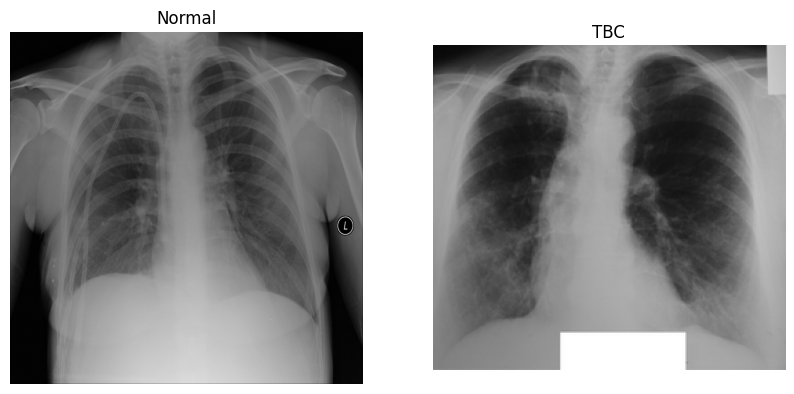

In [50]:
img_normal_path = "/content/tb_dataset/Dataset/Normal/Normal (1).jpg"
img_tbc_path = "/content/tb_dataset/Dataset/Tuberculosis/TB (1).png"

# Read the images using OpenCV
import cv2
img_normal = cv2.imread(img_normal_path, cv2.IMREAD_GRAYSCALE)
img_tbc = cv2.imread(img_tbc_path, cv2.IMREAD_GRAYSCALE)

show_pair(img_normal, img_tbc, "Normal", "TBC")

# Enhancement

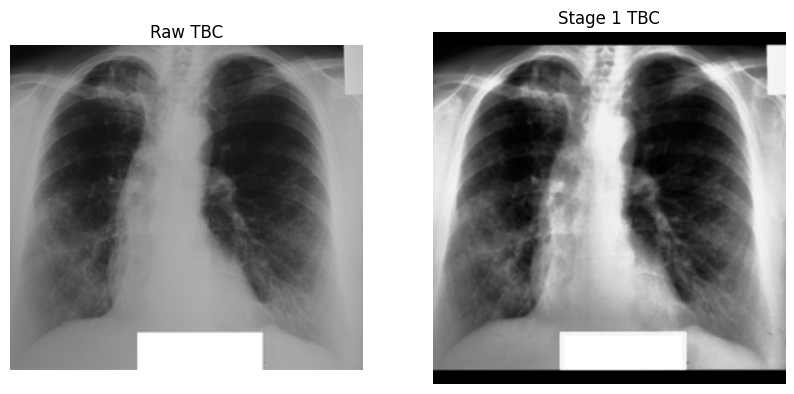

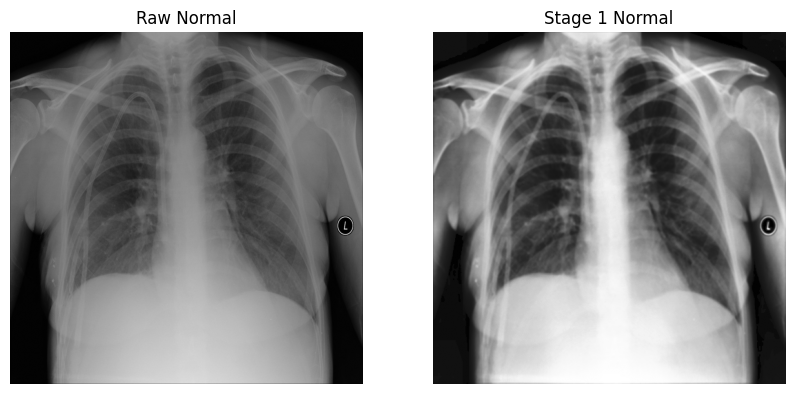

Output Stage 1: Normalize + Bilateral + CLAHE


In [51]:
# ============================================
# 2 — STAGE 1: PREPROCESSING
# ============================================

def stage1_preprocessing(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize preserve aspect ratio
    h, w = img.shape
    target = 512
    scale = target / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    padded = np.zeros((target, target), dtype=np.uint8)
    y_off = (target - new_h) // 2
    x_off = (target - new_w) // 2
    padded[y_off:y_off+new_h, x_off:x_off+new_w] = img

    padded = cv2.GaussianBlur(padded, (5,5), 0)

    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    enhanced = clahe.apply(padded)

    enhanced = cv2.equalizeHist(enhanced)
    enhanced = cv2.normalize(enhanced, None, 0,255, cv2.NORM_MINMAX)

    return enhanced

# --- EXEC ---
tbc_enhanced = stage1_preprocessing(img_tbc)
normal_enhanced = stage1_preprocessing(img_normal)

show_pair(img_tbc, tbc_enhanced, "Raw TBC", "Stage 1 TBC")
show_pair(img_normal, normal_enhanced, "Raw Normal", "Stage 1 Normal")

print("Output Stage 1: Normalize + Bilateral + CLAHE")


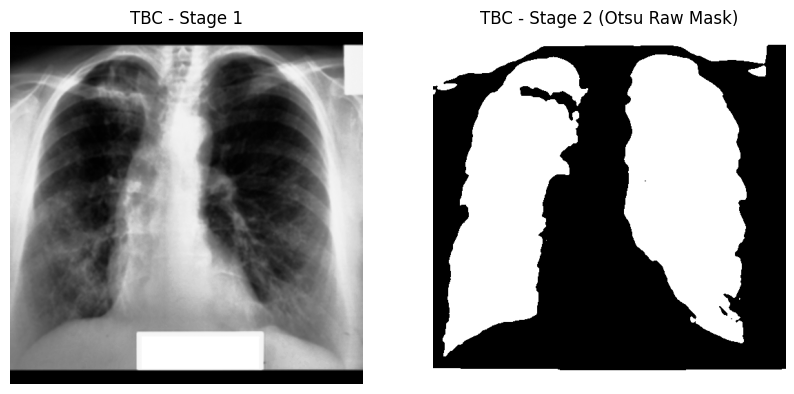

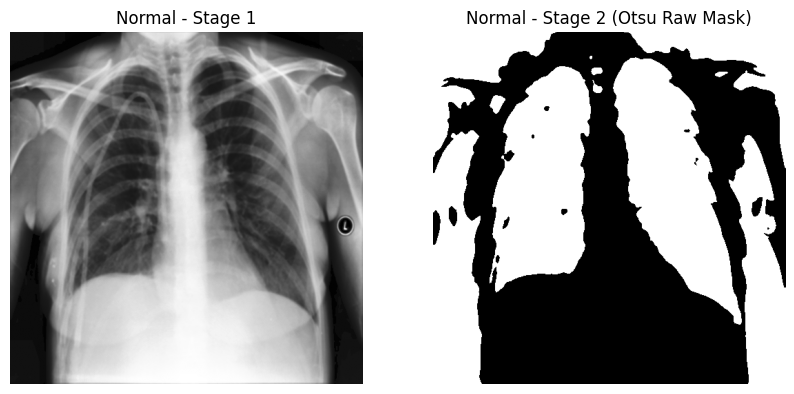

Output Tahap 2: OTSU Threshold (Paru = Putih).


In [52]:
# ============================================
# 3 — STAGE 2: OTSU + FALLBACK
# ============================================

def stage2_threshold(img):
    blur = cv2.GaussianBlur(img, (7,7), 0)
    _, otsu = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    if np.count_nonzero(otsu) < 1200:
        ada = cv2.adaptiveThreshold(
            img, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            51, 3
        )
        if np.count_nonzero(ada) > np.count_nonzero(otsu):
            return ada

    return otsu



# --- EKSEKUSI ---
if 'tbc_enhanced' in globals():
    tbc_seg_raw = stage2_threshold(tbc_enhanced)
    normal_seg_raw = stage2_threshold(normal_enhanced)

    # Tampilkan hasil
    show_pair(tbc_enhanced, tbc_seg_raw, "TBC - Stage 1", "TBC - Stage 2 (Otsu Raw Mask)")
    show_pair(normal_enhanced, normal_seg_raw, "Normal - Stage 1", "Normal - Stage 2 (Otsu Raw Mask)")

    print("Output Tahap 2: OTSU Threshold (Paru = Putih).")


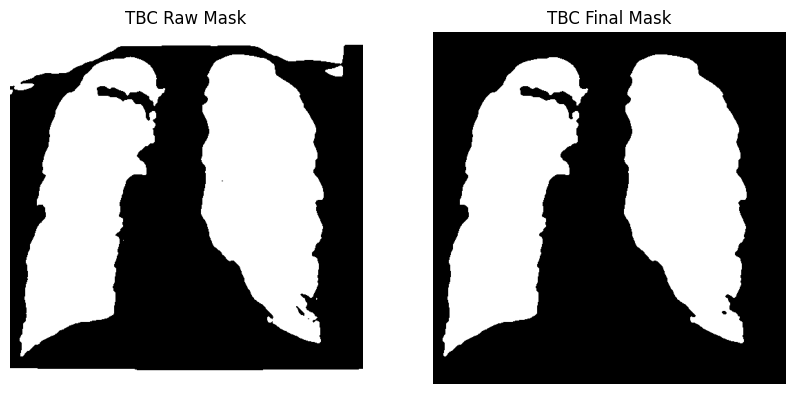

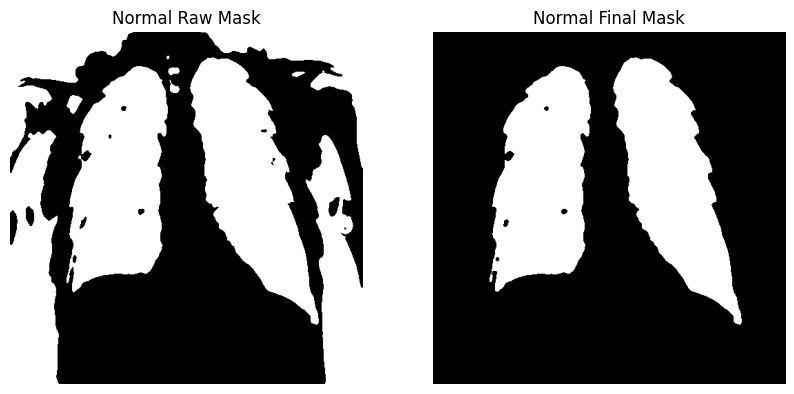

In [53]:
# ============================================
# 4 — STAGE 3: MORPHOLOGY CLEAN
# ============================================

def stage3_clean(mask):
    if np.count_nonzero(mask) < 800:
        return mask

    # Morfologi ringan
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN,  k_open)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned)

    H, W = mask.shape
    candidates = []

    for i in range(1, num):
        x, y, w, h, area = stats[i]

        aspect = h / (w + 1e-5)
        cx = x + w/2

        # filter geometric
        if area < 0.02 * H * W:            # area terlalu kecil
            continue
        if area > 0.45 * H * W:            # kebesaran (kemungkinan body/shadow)
            continue
        if aspect < 1.2:                   # paru harus lebih tinggi dari lebar
            continue
        if cx < W*0.15 or cx > W*0.85:     # terlalu pinggir
            continue

        candidates.append((area, i))

    # sort by area
    candidates = sorted(candidates, reverse=True)

    # Paru ada 2
    if len(candidates) < 2:
        return cleaned

    take = [candidates[0][1], candidates[1][1]]

    final = np.zeros_like(mask)
    for lab in take:
        final[labels == lab] = 255

    final = cv2.medianBlur(final, 3)
    return final


# -------------------------
# EXEC
# -------------------------
tbc_final   = stage3_clean(tbc_seg_raw)
normal_final = stage3_clean(normal_seg_raw)

show_pair(tbc_seg_raw, tbc_final,      "TBC Raw Mask",    "TBC Final Mask")
show_pair(normal_seg_raw, normal_final, "Normal Raw Mask", "Normal Final Mask")


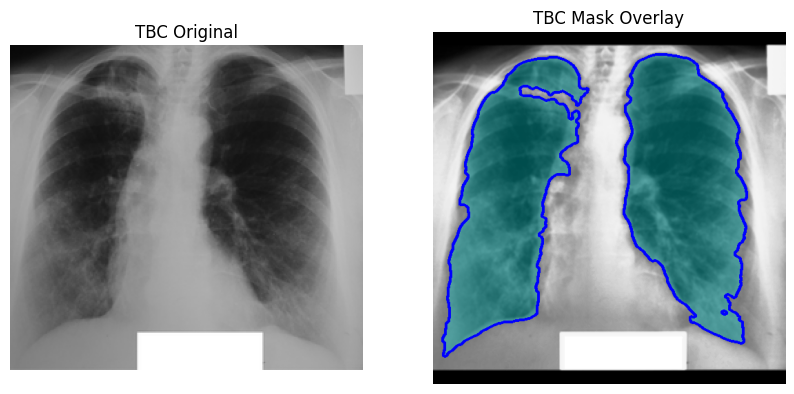

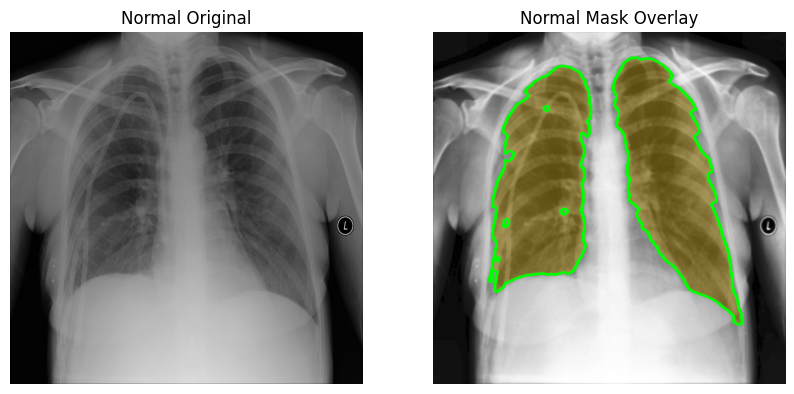

In [54]:
def colored_border(mask, color=(0,0,255), ksize=5):
    mask_bin = (mask > 0).astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    border = cv2.morphologyEx(mask_bin, cv2.MORPH_GRADIENT, k)

    border_color = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    border_color[border > 0] = color
    return border_color

def colored_mask(mask, color=(0,255,255), alpha=0.35):
    # warna mask
    mask_color = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    mask_color[mask > 0] = color

    return mask_color, alpha

def overlay_on_image(img, mask_color, alpha, border_color):
    # mask overlay
    mask_indices = (mask_color.sum(axis=2) > 0)
    overlay = img.copy()
    overlay[mask_indices] = (
        (1 - alpha) * img[mask_indices] +
        alpha * mask_color[mask_indices]
    ).astype(np.uint8)

    # border override
    border_idx = (border_color.sum(axis=2) > 0)
    overlay[border_idx] = border_color[border_idx]

    return overlay

# Convert the 512x512 enhanced grayscale images to 3-channel for overlaying colored masks.
tbc_base_for_overlay = cv2.cvtColor(tbc_enhanced, cv2.COLOR_GRAY2BGR)
normal_base_for_overlay = cv2.cvtColor(normal_enhanced, cv2.COLOR_GRAY2BGR)

# warna: BGR
tbc_border  = colored_border(tbc_final,  color=(0,0,255))      # merah
tbc_maskcol, talpha = colored_mask(tbc_final,  color=(0,255,255), alpha=0.30)

normal_border  = colored_border(normal_final, color=(0,255,0)) # hijau
normal_maskcol, nalpha = colored_mask(normal_final, color=(255,200,0), alpha=0.30)

tbc_overlay = overlay_on_image(tbc_base_for_overlay, tbc_maskcol, talpha, tbc_border)
normal_overlay = overlay_on_image(normal_base_for_overlay, normal_maskcol, nalpha, normal_border)

# Use the original (grayscale) images for comparison in show_pair.
show_pair(img_tbc, tbc_overlay,
          "TBC Original", "TBC Mask Overlay")

show_pair(img_normal, normal_overlay,
          "Normal Original", "Normal Mask Overlay")

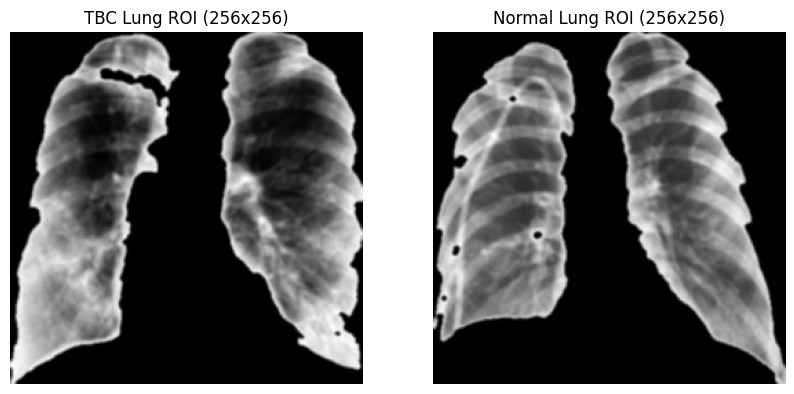

In [69]:
# ============================================
# 5 — STAGE 4: ROI 256x256
# ============================================

def stage4_apply_mask(img_preprocessed, mask_clean):
    lung = cv2.bitwise_and(img_preprocessed, img_preprocessed, mask=mask_clean)

    ys, xs = np.where(mask_clean == 255)
    if len(xs) == 0:
        return None

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    roi = lung[y1:y2, x1:x2]
    roi = cv2.resize(roi, (256,256), interpolation=cv2.INTER_AREA)

    roi = cv2.GaussianBlur(roi, (3,3), 0)
    roi = cv2.normalize(roi, None, 0,255, cv2.NORM_MINMAX)

    return roi

tbc_roi    = stage4_apply_mask(tbc_enhanced, tbc_final)
normal_roi = stage4_apply_mask(normal_enhanced, normal_final)

show_pair(tbc_roi, normal_roi,
          "TBC Lung ROI (256x256)",
          "Normal Lung ROI (256x256)")



# Feature

In [67]:
# ============================================
# 6 — EKSTRAKSI FITUR (LBP, HOG, GLCM, HIST)
# ============================================

def extract_features(img):
    if img is None:
        return np.zeros(200,)

    pixels = img[img > 0].ravel()
    if len(pixels) == 0:
        return np.zeros(200,)

    # Statistik
    stats_feat = [
        np.mean(pixels),
        np.std(pixels),
        np.min(pixels),
        np.max(pixels),
        shannon_entropy(pixels),
        skew(pixels),
        kurtosis(pixels)
    ]

    # Histogram
    hist, _ = np.histogram(pixels, bins=32, range=(0,255), density=True)

    # GLCM
    glcm = graycomatrix(img, distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256, symmetric=True, normed=True)

    glcm_feat = [
        np.mean(graycoprops(glcm,'contrast')),
        np.mean(graycoprops(glcm,'dissimilarity')),
        np.mean(graycoprops(glcm,'homogeneity')),
        np.mean(graycoprops(glcm,'energy')),
        np.mean(graycoprops(glcm,'correlation')),
        np.mean(graycoprops(glcm,'ASM'))
    ]

    # LBP
    lbp = local_binary_pattern(img, 8, 1, method='ror')
    lbp_hist, _ = np.histogram(lbp, bins=59, range=(0,59), density=True)

    # HOG
    hog_feat = hog(img, orientations=9, pixels_per_cell=(32,32),
                   cells_per_block=(1,1), block_norm='L2-Hys')

    return np.hstack([stats_feat, hist, glcm_feat, lbp_hist, hog_feat])


In [76]:
# ============================================
# 7 — BATCH EKSTRAKSI FITUR (DENGAN LIMIT DATA)
# ============================================

folder_normal = "/content/tb_dataset/Dataset/Normal"
folder_tbc    = "/content/tb_dataset/Dataset/Tuberculosis"

# Limit data yang diekstraksi per kelas
max_samples = 3500   # ubah sesuai kebutuhan tugas

features = []
labels   = []

# --------------------------------------------
# Fungsi proses satu gambar
# --------------------------------------------
def process_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img1 = stage1_preprocessing(img)
    m1   = stage2_threshold(img1)
    m2   = stage3_clean(m1)
    roi  = stage4_apply_mask(img1, m2)

    return extract_features(roi)

# --------------------------------------------
# Loader dengan LIMIT
# --------------------------------------------
def load_folder(folder, label, max_samples):
    count = 0
    print(f"\n============================================")
    print(f"  MEMPROSES FOLDER: {folder}")
    print(f"  LABEL: {label} (LIMIT = {max_samples})")
    print(f"============================================")

    for fname in tqdm(sorted(os.listdir(folder))):
        if count >= max_samples:
            break

        if not fname.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif")):
            continue

        fpath = os.path.join(folder, fname)
        feats = process_image(fpath)

        if feats is not None:
            features.append(feats)
            labels.append(label)
            count += 1

    print(f"  -> Total diekstrak: {count} sampel")

# --------------------------------------------
# Eksekusi batch untuk NORMAL & TBC
# --------------------------------------------
load_folder(folder_normal, 0, max_samples)
load_folder(folder_tbc, 1, max_samples)

# Array final
X = np.array(features)
y = np.array(labels)

print("\n============================================")
print("DATASET FINAL:", X.shape)
print("============================================")



  MEMPROSES FOLDER: /content/tb_dataset/Dataset/Normal
  LABEL: 0 (LIMIT = 3500)


100%|██████████| 3500/3500 [05:55<00:00,  9.86it/s]


  -> Total diekstrak: 3500 sampel

  MEMPROSES FOLDER: /content/tb_dataset/Dataset/Tuberculosis
  LABEL: 1 (LIMIT = 3500)


100%|██████████| 3500/3500 [05:34<00:00, 10.45it/s]

  -> Total diekstrak: 3500 sampel

DATASET FINAL: (7000, 680)


In [80]:
# ============================================
# 7.1 — SIMPAN HASIL EKSTRAKSI KE DATAFRAME
# ============================================

# Tentukan jumlah fitur
feat_len = X.shape[1]

# Generate nama kolom generik, misalnya F_0, F_1, ..., F_n
col_names = [f"F_{i}" for i in range(feat_len)]

# Build DataFrame
df = pd.DataFrame(X, columns=col_names)
df["Label"] = y

print("\n============================================")
print("DATAFRAME BERHASIL DIBUAT")
print("Ukuran DF:", df.shape)
print("============================================")

# (Opsional) Simpan CSV
output_csv = "dataset_pcd_features.csv"
df.to_csv(output_csv, index=False)

print(f"CSV berhasil disimpan ke: {output_csv}")



DATAFRAME BERHASIL DIBUAT
Ukuran DF: (7000, 681)
CSV berhasil disimpan ke: dataset_pcd_features.csv


## Feature Extraction Result

In [74]:
list(df.columns)


['F_0',
 'F_1',
 'F_2',
 'F_3',
 'F_4',
 'F_5',
 'F_6',
 'F_7',
 'F_8',
 'F_9',
 'F_10',
 'F_11',
 'F_12',
 'F_13',
 'F_14',
 'F_15',
 'F_16',
 'F_17',
 'F_18',
 'F_19',
 'F_20',
 'F_21',
 'F_22',
 'F_23',
 'F_24',
 'F_25',
 'F_26',
 'F_27',
 'F_28',
 'F_29',
 'F_30',
 'F_31',
 'F_32',
 'F_33',
 'F_34',
 'F_35',
 'F_36',
 'F_37',
 'F_38',
 'F_39',
 'F_40',
 'F_41',
 'F_42',
 'F_43',
 'F_44',
 'F_45',
 'F_46',
 'F_47',
 'F_48',
 'F_49',
 'F_50',
 'F_51',
 'F_52',
 'F_53',
 'F_54',
 'F_55',
 'F_56',
 'F_57',
 'F_58',
 'F_59',
 'F_60',
 'F_61',
 'F_62',
 'F_63',
 'F_64',
 'F_65',
 'F_66',
 'F_67',
 'F_68',
 'F_69',
 'F_70',
 'F_71',
 'F_72',
 'F_73',
 'F_74',
 'F_75',
 'F_76',
 'F_77',
 'F_78',
 'F_79',
 'F_80',
 'F_81',
 'F_82',
 'F_83',
 'F_84',
 'F_85',
 'F_86',
 'F_87',
 'F_88',
 'F_89',
 'F_90',
 'F_91',
 'F_92',
 'F_93',
 'F_94',
 'F_95',
 'F_96',
 'F_97',
 'F_98',
 'F_99',
 'F_100',
 'F_101',
 'F_102',
 'F_103',
 'F_104',
 'F_105',
 'F_106',
 'F_107',
 'F_108',
 'F_109',
 'F_110',


# Modelling and Evaluation

🌲 Melatih Random Forest...
🚀 Melatih Gradient Boosting...
⚔️ Melatih SVM...

========== HASIL RANDOM FOREST ==========
🎯 Akurasi: 90.21%
              precision    recall  f1-score   support

      Normal       0.90      0.91      0.90       711
         TBC       0.90      0.90      0.90       689

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400



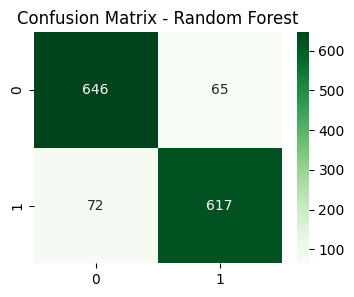


========== HASIL GRADIENT BOOSTING ==========
🎯 Akurasi: 92.64%
              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       711
         TBC       0.94      0.91      0.92       689

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400



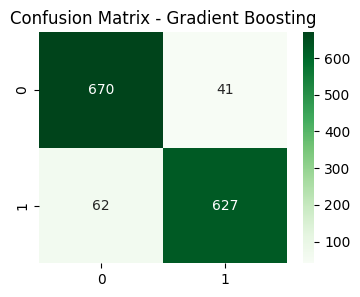


========== HASIL SVM ==========
🎯 Akurasi: 91.07%
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.91       711
         TBC       0.91      0.90      0.91       689

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400



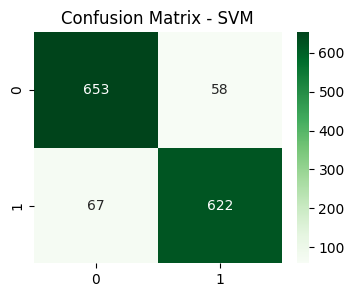


🏆 TOP 20 FITUR PALING BERPENGARUH (SVM):
1. F_60 	(0.1583) ✨ (LBP)
2. F_4 	(0.1190) 🔥 (Stat)
3. F_648 	(0.1007) ⭐ (HOG)
4. F_639 	(0.0400) ⭐ (HOG)
5. F_332 	(0.0332) ⭐ (HOG)
6. F_43 	(0.0270) 🔥 (GLCM)
7. F_40 	(0.0269) 🔥 (GLCM)
8. F_52 	(0.0233) ✨ (LBP)
9. F_7 	(0.0207) 📊 (Hist)
10. F_62 	(0.0200) ✨ (LBP)
11. F_144 	(0.0163) ⭐ (HOG)
12. F_548 	(0.0099) ⭐ (HOG)
13. F_382 	(0.0099) ⭐ (HOG)
14. F_45 	(0.0095) ✨ (LBP)
15. F_239 	(0.0094) ⭐ (HOG)
16. F_6 	(0.0088) 🔥 (Stat)
17. F_460 	(0.0086) ⭐ (HOG)
18. F_556 	(0.0075) ⭐ (HOG)
19. F_56 	(0.0060) ✨ (LBP)
20. F_318 	(0.0059) ⭐ (HOG)


In [78]:
# 7


# 1. Load Data LENGKAP (87 Fitur)
# df = pd.read_csv('dataset_1000_images_complete.csv')

# Handle NaN values introduced during feature extraction
df.fillna(0, inplace=True)

# 2. Pisahkan Fitur & Label
# X = df.drop('Label', axis=1)
# y = df['Label']

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scaling (Wajib untuk SVM dan HOG yang nilainya kecil)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- MODEL 1: RANDOM FOREST ---
print("🌲 Melatih Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- MODEL 2: GRADIENT BOOSTING ---
print("🚀 Melatih Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# --- MODEL 3: SVM ---
print("⚔️ Melatih SVM...")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# --- EVALUASI ---
def show_result(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{'='*10} HASIL {model_name.upper()} {'='*10}")
    print(f"🎯 Akurasi: {acc*100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'TBC']))

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

show_result("Random Forest", y_test, y_pred_rf)
show_result("Gradient Boosting", y_test, y_pred_gb)
show_result("SVM", y_test, y_pred_svm)

# --- FEATURE IMPORTANCE (Cek apakah HOG/LBP berguna?) ---
# Using Gradient Boosting model for feature importances
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Define feature ranges based on `extract_features` function
stats_idx_end = 7
hist_idx_end = stats_idx_end + 32  # 39
glcm_idx_end = hist_idx_end + 6    # 45
lbp_idx_end = glcm_idx_end + 59     # 104
hog_idx_end = lbp_idx_end + 576     # 680

print("\n🏆 TOP 20 FITUR PALING BERPENGARUH (SVM):")
for i in range(20):
    feature_index = indices[i]
    fitur = col_names[feature_index] # Corrected: Use col_names instead of X.columns
    skor = importances[feature_index]

    # Beri tanda pada fitur baru berdasarkan indeks
    tanda = ""
    if feature_index >= stats_idx_end and feature_index < hist_idx_end: tanda = "📊 (Hist)"
    elif feature_index >= hist_idx_end and feature_index < glcm_idx_end: tanda = "🔥 (GLCM)"
    elif feature_index >= glcm_idx_end and feature_index < lbp_idx_end: tanda = "✨ (LBP)"
    elif feature_index >= lbp_idx_end and feature_index < hog_idx_end: tanda = "⭐ (HOG)"
    elif feature_index < stats_idx_end: tanda = "🔥 (Stat)"

    print(f"{i+1}. {fitur} \t({skor:.4f}) {tanda}")

In [81]:
# CELL 1: Setup & load dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, RocCurveDisplay,
                             precision_recall_fscore_support)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import joblib
from tqdm import tqdm

# Path ke CSV hasil cell 6
##csv_path = "dataset_features_fixed.csv"   # ganti kalau perlu

# load
#df = pd.read_csv(csv_path) # df is already loaded from previous cells
# print("Loaded:", csv_path, "shape:", df.shape) # This line was causing the error

# drop non-feature columns if exist
for c in ['source_path', 'path', 'filename']:
    if c in df.columns:
        df = df.drop(columns=[c])

# Basic check
print("Columns:", len(df.columns)-1, "features + Label column present?" , 'Label' in df.columns)
X = df.drop(columns=['Label']).values
y = df['Label'].values

print("X shape:", X.shape, "y shape:", y.shape)

Columns: 680 features + Label column present? True
X shape: (7000, 680) y shape: (7000,)


In [82]:
# CELL 2: Preprocessing, optional feature selection, and PCA preparation

# 1) Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) Quick correlation check (optional, just to inspect)
corrmat = pd.DataFrame(X_scaled, columns=df.drop(columns=['Label']).columns).corr().abs()
# If you want to inspect high correlations, uncomment:
# high_corr = np.where(np.triu(corrmat.values, k=1) > 0.95)
# print("High correlation pairs:", [(corrmat.columns[i], corrmat.columns[j]) for i,j in zip(*high_corr)])

# 3) Feature selection experiments (we'll keep them to compare)
#    A) Mutual Information top K
K_sel = 200   # you can vary (200 -> then PCA 50)
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(K_sel, X.shape[1]))
selector_chi2 = SelectKBest(score_func=chi2, k=min(K_sel, X.shape[1]))

X_mi = selector_mi.fit_transform(X_scaled, y)
X_chi2 = selector_chi2.fit_transform(np.clip(X_scaled, 0, None), y)  # chi2 needs non-negative

print("Selected (MI) shape:", X_mi.shape, "Selected (Chi2) shape:", X_chi2.shape)

# 4) PCA target: 50 components (or less if features less)
pca_n = 50
pca = PCA(n_components=min(pca_n, X_scaled.shape[1]), random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio (sum):", pca.explained_variance_ratio_.sum())


Selected (MI) shape: (7000, 200) Selected (Chi2) shape: (7000, 200)
PCA explained variance ratio (sum): 0.5750819018124745



=== CV for RandomForest ===
Precision mean±std: (np.float64(0.8772582256761844), np.float64(0.008042653790745959))
Recall mean±std: (np.float64(0.871142857142857), np.float64(0.011043513194335799))
F1 mean±std: (np.float64(0.8741230781760712), np.float64(0.005964051631813674))
AUC mean±std: (np.float64(0.949164693877551), np.float64(0.0044075607392454145))

=== CV for GradientBoosting ===
Precision mean±std: (np.float64(0.865488385801678), np.float64(0.010905685835477078))
Recall mean±std: (np.float64(0.8559999999999999), np.float64(0.012948879078428188))
F1 mean±std: (np.float64(0.8606566673338214), np.float64(0.009543915113087413))
AUC mean±std: (np.float64(0.9388167346938776), np.float64(0.005565925876450498))

=== CV for SVM ===
Precision mean±std: (np.float64(0.9143909540561627), np.float64(0.005096997713679861))
Recall mean±std: (np.float64(0.8902857142857143), np.float64(0.01748235261803242))
F1 mean±std: (np.float64(0.9020613129541027), np.float64(0.008231191524445345))
AUC me

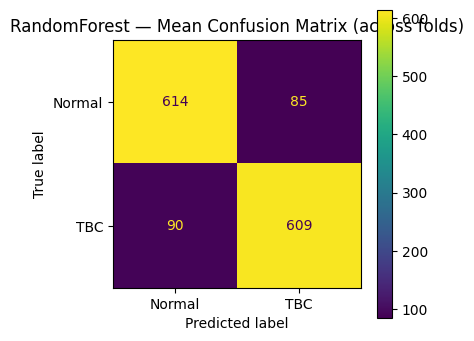


GradientBoosting — Confusion matrix (mean):
 [[606.8  93.2]
 [100.8 599.2]]
GradientBoosting — Confusion matrix (std):
 [[8.45 8.45]
 [9.06 9.06]]


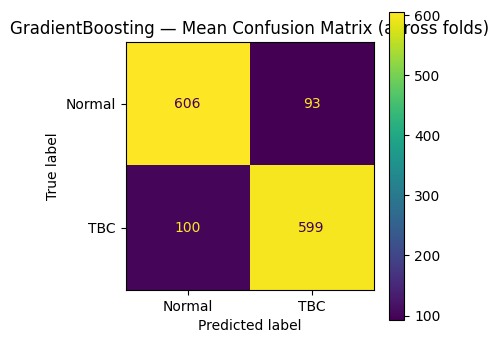


SVM — Confusion matrix (mean):
 [[641.6  58.4]
 [ 76.8 623.2]]
SVM — Confusion matrix (std):
 [[ 4.32  4.32]
 [12.24 12.24]]


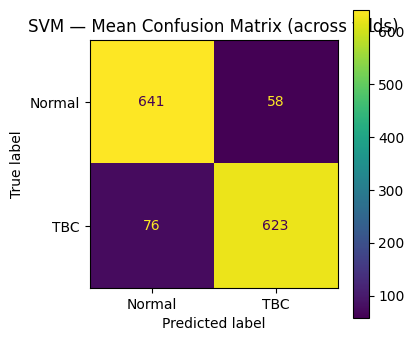

In [ ]:
# CELL 3: Cross-validation K=5 (single run). Collect confusion matrices + ROC per model.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Choose feature path: options: "all", "mi", "chi2", "pca"
feature_option = "pca"   # recommended: "pca" (50D). Other options: "all", "mi", "chi2"
if feature_option == "all":
    X_use = X_scaled
elif feature_option == "mi":
    X_use = X_mi
elif feature_option == "chi2":
    X_use = X_chi2
elif feature_option == "pca":
    X_use = X_pca
else:
    raise ValueError("Unknown feature_option")

results = {}
for name, model in models.items():
    print("\n=== CV for", name, "===")
    cms = []    # confusion matrices per fold
    aucs = []   # auc per fold
    precisions = []
    recalls = []
    f1s = []

    # Do cross_val_predict for probabilities if available
    y_pred = cross_val_predict(model, X_use, y, cv=cv, method='predict', n_jobs=-1)
    if hasattr(model, "predict_proba"):
        y_proba = cross_val_predict(model, X_use, y, cv=cv, method='predict_proba', n_jobs=-1)[:,1]
    else:
        # SVM with probability=True supports predict_proba; fallback: decision_function -> sigmoid
        try:
            y_proba = cross_val_predict(model, X_use, y, cv=cv, method='decision_function', n_jobs=-1)
            # scaled into 0-1 via min-max for ROC (ok for ranking)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)
        except:
            y_proba = None

    # compute metrics per fold manually to capture conf matrices
    for train_idx, test_idx in cv.split(X_use, y):
        model.fit(X_use[train_idx], y[train_idx])
        yp = model.predict(X_use[test_idx])
        cms.append(confusion_matrix(y[test_idx], yp))
        p, r, f, _ = precision_recall_fscore_support(y[test_idx], yp, average='binary', pos_label=1)
        precisions.append(p); recalls.append(r); f1s.append(f)
        if y_proba is not None:
            # get ROC AUC for this fold using model.predict_proba on test set
            proba = model.predict_proba(X_use[test_idx])[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_use[test_idx])
            fpr, tpr, _ = roc_curve(y[test_idx], proba)
            aucs.append(auc(fpr, tpr))

    cms = np.array(cms)
    results[name] = {
        "cms": cms,
        "precision": (np.mean(precisions), np.std(precisions)),
        "recall": (np.mean(recalls), np.std(recalls)),
        "f1": (np.mean(f1s), np.std(f1s)),
        "auc_mean": (np.mean(aucs) if len(aucs)>0 else None, np.std(aucs) if len(aucs)>0 else None),
        "all_aucs": aucs, # Store all individual AUCs per fold
        "y_pred": y_pred,
        "y_proba": y_proba
    }

    # print summary
    print(f"Precision mean±std: {results[name]['precision']}")
    print(f"Recall mean±std: {results[name]['recall']}")
    print(f"F1 mean±std: {results[name]['f1']}")
    if results[name]['auc_mean'][0] is not None:
        print(f"AUC mean±std: {results[name]['auc_mean']}")

# Display aggregated confusion matrices (mean ± std)
for name, r in results.items():
    mean_cm = np.mean(r['cms'], axis=0)
    std_cm = np.std(r['cms'], axis=0)
    print(f"\n{name} — Confusion matrix (mean):\n", mean_cm.round(2))
    print(f"{name} — Confusion matrix (std):\n", std_cm.round(2))

    disp = ConfusionMatrixDisplay(mean_cm.astype(int), display_labels=["Normal","TBC"])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, values_format='d')
    plt.title(f"{name} — Mean Confusion Matrix (across folds)")
    plt.show()


In [ ]:
# CELL 4: Multi-run repeated CV (e.g., 5 repeats)
from sklearn.model_selection import RepeatedStratifiedKFold

n_repeats = 5
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
multi_results = {}

for name, model in models.items():
    cms = []
    aucs = []
    fold = 0
    for train_idx, test_idx in tqdm(rkf.split(X_use, y), total=5*n_repeats, desc=f"Multi-run {name}"):
        model.fit(X_use[train_idx], y[train_idx])
        yp = model.predict(X_use[test_idx])
        cms.append(confusion_matrix(y[test_idx], yp))
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_use[test_idx])[:,1]
            fpr, tpr, _ = roc_curve(y[test_idx], proba)
            aucs.append(auc(fpr,tpr))
    cms = np.array(cms)
    multi_results[name] = {
        "cms_mean": np.mean(cms, axis=0),
        "cms_std": np.std(cms, axis=0),
        "auc_mean": (np.mean(aucs) if len(aucs)>0 else None, np.std(aucs) if len(aucs)>0 else None)
    }
    print(f"\n{name} multi-run CM mean:\n", multi_results[name]['cms_mean'].round(2))
    print(f"{name} multi-run CM std:\n", multi_results[name]['cms_std'].round(2))
    if multi_results[name]['auc_mean'][0] is not None:
        print(f"{name} multi-run AUC mean±std:", multi_results[name]['auc_mean'])


In [ ]:
# CELL 5: ROC curve per model (using cross_val_predict probabilities from CELL 3 results)
plt.figure(figsize=(8,6))
for name, r in results.items():
    y_proba = r['y_proba']
    if y_proba is None:
        continue
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--', linewidth=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves (feature_option={feature_option})")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# utils_evaluation.py
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 1) Statistical significance (paired t-test + Wilcoxon)
# --------------------------
def paired_tests(metric_a, metric_b, names=('A','B'), alpha=0.05):
    """
    metric_a, metric_b: arrays of shape (n_runs,) e.g. AUCs from multiple runs or folds
    prints paired t-test and Wilcoxon signed-rank test
    """
    metric_a = np.asarray(metric_a)
    metric_b = np.asarray(metric_b)
    assert metric_a.shape == metric_b.shape, "Shapes must match (n_runs,)"
    t_stat, p_t = stats.ttest_rel(metric_a, metric_b)
    try:
        w_stat, p_w = stats.wilcoxon(metric_a, metric_b)
    except Exception:
        w_stat, p_w = np.nan, np.nan
    print(f"Paired t-test {names[0]} vs {names[1]}: t={t_stat:.4f}, p={p_t:.4e} -> {'signif' if p_t<alpha else 'n.s.'}")
    print(f"Wilcoxon {names[0]} vs {names[1]}: W={w_stat}, p={p_w:.4e} -> {'signif' if (not np.isnan(p_w) and p_w<alpha) else 'n.s.'}")
    return {'t_stat':t_stat,'p_t':p_t,'w_stat':w_stat,'p_w':p_w}

# --------------------------
# 2) Bootstrap CI for AUC
# --------------------------
def auc_bootstrap_ci(y_true, y_score, n_bootstraps=2000, alpha=0.95, random_state=None):
    """
    Returns (auc_mean, (lower, upper)) using bootstrap on sample-level predictions
    y_true, y_score are 1D arrays for single run
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    n = len(y_true)
    aucs = []
    for i in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            # skip bootstrap samples with only one class
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    aucs = np.array(aucs)
    mean = aucs.mean()
    lo = np.percentile(aucs, (1 - alpha) / 2 * 100)
    hi = np.percentile(aucs, (1 + alpha) / 2 * 100)
    return mean, (lo, hi)

# --------------------------
# 3) Youden's J threshold optimization
# --------------------------
def youden_threshold(y_true, y_score):
    """
    Returns threshold maximizing Youden's J = sens + spec - 1
    and dictionary with sens, spec at that threshold
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    youden = tpr - fpr
    idx = np.argmax(youden)
    th = thresholds[idx]
    sens = tpr[idx]
    spec = 1 - fpr[idx]
    return th, {'sensitivity': sens, 'specificity': spec, 'youden': youden[idx]}

# --------------------------
# 4) Summarize multi-run results (preds/scores per run)
# --------------------------
def summarize_multi_run(y_true, scores_runs, preds_runs=None, threshold=0.5, verbose=True):
    """
    y_true: 1D array ground truth (same for all runs)
    scores_runs: list or array shape (n_runs, n_samples) predicted probability/scores
    preds_runs: optional list or array shape (n_runs, n_samples) of binary preds. If None, apply threshold.
    Returns DataFrame with metrics per run and aggregated mean±std
    """
    y_true = np.asarray(y_true)
    scores_runs = np.asarray(scores_runs)
    n_runs = scores_runs.shape[0]
    rows = []
    for r in range(n_runs):
        scores = scores_runs[r]
        if preds_runs is None:
            preds = (scores >= threshold).astype(int)
        else:
            preds = np.asarray(preds_runs)[r]
        prec, recall, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', pos_label=1)
        auc = roc_auc_score(y_true, scores)
        cm = confusion_matrix(y_true, preds)
        tn, fp, fn, tp = cm.ravel()
        sens = tp / (tp + fn)
        spec = tn / (tn + fp)
        rows.append({'run': r, 'precision': prec, 'recall': recall, 'f1': f1, 'auc': auc,
                     'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn, 'sensitivity': sens, 'specificity': spec})
    df = pd.DataFrame(rows)
    agg = df.agg(['mean','std']).T
    if verbose:
        print("Per-run metric means (mean ± std):")
        for m in ['precision','recall','f1','auc','sensitivity','specificity']:
            print(f"{m}: {agg.loc[m,'mean']:.4f} \u00b1 {agg.loc[m,'std']:.4f}")
        print("\nConfusion matrix (mean):")
        print(np.array([[agg.loc['tn','mean'], agg.loc['fp','mean']],[agg.loc['fn','mean'], agg.loc['tp','mean']]]))
    return df, agg

# --------------------------
# 5) Plot ROC with mean+std from multi-run scores
# --------------------------
def plot_mean_roc(y_true, scores_runs, label=None):
    """
    plots per-run ROC curves plus mean \u00b1 std band (interpolated on a common fpr grid)
    """
    y_true = np.asarray(y_true)
    scores_runs = np.asarray(scores_runs)
    tprs = []
    base_fpr = np.linspace(0,1,101)
    aucs = []
    for r in range(scores_runs.shape[0]):
        fpr, tpr, _ = roc_curve(y_true, scores_runs[r])
        aucs.append(roc_auc_score(y_true, scores_runs[r]))
        # interpolate tpr onto base_fpr
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    plt.plot(base_fpr, mean_tpr, label=f"{label} (AUC mean={np.mean(aucs):.3f})")
    plt.fill_between(base_fpr, np.clip(mean_tpr-std_tpr,0,1), np.clip(mean_tpr+std_tpr,0,1), alpha=0.2)

# --------------------------
# 6) Learning curve utility
# --------------------------
def plot_learning_curve(estimator, X, y, cv=5, scoring='roc_auc', n_jobs=1, train_sizes=np.linspace(.1,1.0,5)):
    """
    Plots learning curve (train/test scores) for estimator
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(train_sizes, test_mean, 'o-', label='CV')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    plt.legend(loc='best')
    plt.grid(True)

# --------------------------
# 7) Ablation study helper
# --------------------------
def ablation_study(X_dict, y, estimator, cv=5, scoring='roc_auc', n_jobs=1):
    """
    X_dict: dict of {'name': X_matrix}
    estimator: classifier instance (unfitted)
    runs cross_val_score for each feature set and returns summary DataFrame
    """
    results = []
    for name, X in X_dict.items():
        # use StratifiedKFold to get per-fold scores
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        fold_scores = []
        for train_idx, test_idx in skf.split(X, y):
            estimator.fit(X[train_idx], y[train_idx])
            probs = estimator.predict_proba(X[test_idx])[:,1]
            fold_scores.append(roc_auc_score(y[test_idx], probs))
        results.append({'feature_set': name, 'mean_auc': np.mean(fold_scores), 'std_auc': np.std(fold_scores)})
    df = pd.DataFrame(results).sort_values('mean_auc', ascending=False)
    return df

# --------------------------
# Example usage (paste in your notebook)
# --------------------------

# Example: significance tests on stored AUC lists
# Assuming `results` dictionary is available from previous cells and modified to store 'all_aucs'
if 'results' in globals() and 'SVM' in results and 'RandomForest' in results:
    aucs_svm = results['SVM']['all_aucs']
    aucs_rf = results['RandomForest']['all_aucs']
    if aucs_svm and aucs_rf:
        paired_tests(aucs_svm, aucs_rf, names=('SVM','RF'))
    else:
        print("AUC lists for SVM or RandomForest are empty. Cannot perform paired tests.")
else:
    print("Results from cross-validation (CELL 3) not available or incomplete.")

# Placeholder variables for other examples; replace with actual data if available
y_true = y
y_score = results['SVM']['y_proba'] if 'results' in globals() and 'SVM' in results else None
scores_runs = np.array([results[model_name]['y_proba'] for model_name in results]) if 'results' in globals() else None
rf_scores_runs = np.array([results['RandomForest']['y_proba']]) if 'results' in globals() and 'RandomForest' in results else None
gb_scores_runs = np.array([results['GradientBoosting']['y_proba']]) if 'results' in globals() and 'GradientBoosting' in results else None
svm_scores_runs = np.array([results['SVM']['y_proba']]) if 'results' in globals() and 'SVM' in results else None
svm_estimator = models['SVM'] if 'models' in globals() and 'SVM' in models else None # assuming 'models' is available
X_hog = X_use # Example placeholder
X_lbp = X_use # Example placeholder
X_glcm = X_use # Example placeholder
X_all = X_use # Example placeholder



# Bootstrap CI for one run:
if y_true is not None and y_score is not None:
    mean_auc, (lo, hi) = auc_bootstrap_ci(y_true, y_score, n_bootstraps=2000)
    print(f"AUC {mean_auc:.4f}, 95% CI [{lo:.4f}, {hi:.4f}]")
else:
    print("Cannot perform Bootstrap CI: y_true or y_score not available.")

# Youden threshold:
if y_true is not None and y_score is not None:
    th, info = youden_threshold(y_true, y_score)
    print("Youden threshold:", th, info)
else:
    print("Cannot determine Youden threshold: y_true or y_score not available.")

# Summarize multi-run:
if scores_runs is not None and len(scores_runs) > 0:
    df_runs, agg = summarize_multi_run(y_true, scores_runs)  # scores_runs shape (n_runs, n_samples)
else:
    print("Cannot summarize multi-run: scores_runs not available or empty.")

# Plot mean ROC for multiple models:
plt.figure(figsize=(6,5))
if rf_scores_runs is not None:
    plot_mean_roc(y_true, rf_scores_runs, label='RandomForest')
if gb_scores_runs is not None:
    plot_mean_roc(y_true, gb_scores_runs, label='GradientBoosting')
if svm_scores_runs is not None:
    plot_mean_roc(y_true, svm_scores_runs, label='SVM')
plt.plot([0,1],[0,1],'k--',alpha=0.3)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid(True)
plt.show()

# Learning curve:
if svm_estimator is not None and X_pca is not None and y is not None:
    plot_learning_curve(svm_estimator, X_pca, y, cv=5, scoring='roc_auc')
else:
    print("Cannot plot learning curve: SVM estimator, X_pca, or y not available.")

# Ablation:
if X_hog is not None and X_lbp is not None and X_glcm is not None and X_all is not None and y is not None and svm_estimator is not None:
    X_dict = {'HOG': X_hog, 'LBP': X_lbp, 'GLCM': X_glcm, 'ALL': X_all}
    ablation_df = ablation_study(X_dict, y, estimator=svm_estimator, cv=5)
    print(ablation_df)
else:
    print("Cannot perform ablation study: required data or estimator not available.")
